In [21]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import os
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from collections import Counter
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic, ICRS
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor

#Data file
file = os.chdir("/home/abhi/Desktop/eROSITA/")

#Importing the data and model parameters
data = pd.read_excel("New  Variables and Transients.xlsx")
data1 = pd.read_csv("Vikas_737_parms.csv")
a_1 = data1["1"].to_numpy().reshape(-1,1)
a_2 = data1["2"].to_numpy().reshape(-1,1)
E_p = data1["3"].to_numpy().reshape(-1,1)
lum_x = data["Luminosity (ergs/sec)"].dropna().to_numpy().reshape(-1,1)
dist = data["Distance"].dropna().to_numpy().reshape(-1,1)
sr_class = data["Source Class"].dropna().to_numpy()
bp_rp = data["bp_rp"].dropna().to_numpy().reshape(-1,1)
Absolute_G = data["Absolute G"].dropna().to_numpy().reshape(-1,1)
Temp = data["Temp (Kelvin)"].dropna().to_numpy().reshape(-1,1)
lum_o = data["luminosity_GAIA (ergs/sec)"].dropna().to_numpy().reshape(-1,1)
radius = data["RADIUS"].dropna().to_numpy().reshape(-1,1)
flux_ratio = data["flux_ratio_final"].dropna().to_numpy().reshape(-1,1)
o_period = data["Final period (Days)"].to_numpy().reshape(-1,1)

if len(o_period) > len(lum_x):
    o_period = o_period[:len(lum_x)]

#Checking the shapes
print("lum_x",np.shape(lum_x))
print("lum_o",np.shape(lum_o))
print("dist",np.shape(dist))
print("bp-rp",np.shape(bp_rp))
print("Temp", np.shape(Temp))
print("radius", np.shape(radius))
print("Absolute_G", np.shape(Absolute_G))
print("orbital_period",np.shape(o_period))

#Changing the elements to nan
lum_o[lum_o == "--"] = np.nan
Temp[Temp == "--"] = np.nan
bp_rp[bp_rp == "--"] = np.nan
radius[radius == "--"] = np.nan

#Checking the length of the array
print(len(radius))
print(len(dist))
print(len(Temp))
print(len(lum_o))

#Checking the source class
count = Counter(sr_class)
print(count)

#Class
class_1 = ["SS_IB","IB","YSO","CV", "XRB"]

#Replacing sources by their numbers
sr_class_new = sr_class

sr_class_new[sr_class_new  == "SS_IB"] = 0
sr_class_new[sr_class_new  == "IB"] = 1
sr_class_new[sr_class_new  == "YSO"] = 2
sr_class_new[sr_class_new  == "CV"] = 3
sr_class_new[sr_class_new  == "XRB"] = 4

# Random Forest Classification
rf_cl = RandomForestClassifier(n_estimators = 1000, random_state=42)
target = np.array(sr_class_new, dtype=int)

#Rodriguez Empirical Cut
flux_ratio = np.log10(flux_ratio)
G_bp_rp_ratio = np.divide(Absolute_G, bp_rp)
f_ratio_Gbp = np.divide(flux_ratio ,(bp_rp * Absolute_G))
feature_period_known = (~np.isnan(o_period)).astype(int).reshape(-1, 1)
feature_period_value = np.nan_to_num(o_period, nan=0.0).reshape(-1, 1)
#feature_period_value = np.where(np.isnan(o_period), np.nanmedian(o_period), o_period)

#Data and Standardization
data_1_obs = np.column_stack((lum_x,dist, Absolute_G,bp_rp,lum_o,flux_ratio,
                            G_bp_rp_ratio,f_ratio_Gbp,feature_period_known,feature_period_value))#a1,a2,Ep,o_period)) = how to adjust the nan vals
data_1_pars = np.column_stack((a_1,a_2,E_p))

y_test_ =[]
y_pred_ = []

#Doing the Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=4 ,shuffle=True, random_state=42)
for (train_index, test_index) in (skf.split(data_1_obs, target)):
    X_train, X_test = data_1_obs[train_index], data_1_obs[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    #Imputing
    imputer = SimpleImputer(strategy='mean')
    #imputer = KNNImputer(n_neighbors=5)
    X_train_t = imputer.fit_transform(X_train)
    X_test_t = imputer.transform(X_test)
    
    #Scaling
    scalar = RobustScaler()
    X_train_t_s = scalar.fit_transform(X_train_t)
    X_test_t_s = scalar.transform(X_test_t)
    
    #Spectral parameters fit- 
    reg_a1 = KNeighborsRegressor(n_neighbors=1).fit(X_train_t_s, a_1[train_index])
    reg_a2 = KNeighborsRegressor(n_neighbors=1).fit(X_train_t_s, a_2[train_index])
    reg_ep = KNeighborsRegressor(n_neighbors=1).fit(X_train_t_s, E_p[train_index])
    
    #SMOTE
    smote = SMOTE(random_state=42, k_neighbors=1)
    smt = SMOTETomek(random_state=42, smote=smote)
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train_t_s, y_train)

    #Fit - train
    a1_resampled = reg_a1.predict(X_train_resampled)
    a2_resampled = reg_a2.predict(X_train_resampled)
    Ep_resampled = reg_ep.predict(X_train_resampled)
    data_final = X_final = np.hstack([X_train_resampled, a1_resampled.reshape(-1, 1),a2_resampled.reshape(-1, 1),Ep_resampled.reshape(-1, 1)])

    #Fit - test
    a1_test = reg_a1.predict(X_test_t_s)
    a2_test = reg_a2.predict(X_test_t_s)
    Ep_test = reg_ep.predict(X_test_t_s)

    # Combine them with test features
    X_test_final = np.hstack([X_test_t_s, a1_test.reshape(-1, 1), a2_test.reshape(-1, 1), Ep_test.reshape(-1, 1)])

    #Classifying
    y_rf_cl = rf_cl.fit(data_final, y_train_resampled)
    y_pred = y_rf_cl.predict(X_test_final)
    y_test_.extend(y_test)
    y_pred_.extend(y_pred)

lum_x (723, 1)
lum_o (723, 1)
dist (723, 1)
bp-rp (723, 1)
Temp (723, 1)
radius (723, 1)
Absolute_G (723, 1)
orbital_period (723, 1)
723
723
723
723
Counter({'SS_IB': 417, 'IB': 160, 'YSO': 105, 'CV': 38, 'XRB': 3})


/home/abhi/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

In [22]:
#Testing the accuracy of the model
print("\nConfusion Matrix:\n", confusion_matrix(y_test_, y_pred_))
print("\nClassification Report:\n", classification_report(y_test_, y_pred_))
print("Accuracy:", accuracy_score(y_test_, y_pred_))


Confusion Matrix:
 [[336  28  51   2   0]
 [ 50 102   8   0   0]
 [ 24   9  72   0   0]
 [  3   2   0  32   1]
 [  3   0   0   0   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       417
           1       0.72      0.64      0.68       160
           2       0.55      0.69      0.61       105
           3       0.94      0.84      0.89        38
           4       0.00      0.00      0.00         3

    accuracy                           0.75       723
   macro avg       0.60      0.59      0.60       723
weighted avg       0.76      0.75      0.75       723

Accuracy: 0.7496542185338866


In [23]:
# ... inside the loop, after fitting the model
# Get feature names
original_features = ['lum_x', 'dist', 'Absolute_G', 'bp_rp', 'lum_o', 'flux_ratio', 
                    'G_bp_rp_ratio', 'f_ratio_Gbp', 'period_known', 'period_value']
imputed_spectral = ['a_1', 'a_2', 'E_p']
all_features = original_features + imputed_spectral

importances = y_rf_cl.feature_importances_
feature_imp_df = pd.DataFrame(importances, index=all_features, columns=['Importance']).sort_values(by='Importance', ascending=False)
print(feature_imp_df)
print("-" * 30)

               Importance
G_bp_rp_ratio    0.158892
flux_ratio       0.122957
lum_x            0.120555
bp_rp            0.111558
dist             0.100152
lum_o            0.087126
Absolute_G       0.067586
f_ratio_Gbp      0.066043
period_value     0.057889
period_known     0.050273
a_1              0.032868
a_2              0.012440
E_p              0.011662
------------------------------


In [ ]:
accy = []
n = [5, 9, 10, 15,16,17,18,20, 50, 80, 95, 100, 110, 130, 250, 350, 500, 1000,2000]

# Predict additional features (a1, a2, Ep) for TRAIN and TEST sets separately
a1_train = reg_a1.predict(X_train)
a2_train = reg_a2.predict(X_train)
Ep_train = reg_ep.predict(X_train)

a1_test = reg_a1.predict(X_test)
a2_test = reg_a2.predict(X_test)
Ep_test = reg_ep.predict(X_test)

# Combine base features + predicted features
X_train_new = np.hstack([X_train, a1_train.reshape(-1,1), a2_train.reshape(-1,1), Ep_train.reshape(-1,1)])
X_test_new  = np.hstack([X_test,  a1_test.reshape(-1,1),  a2_test.reshape(-1,1),  Ep_test.reshape(-1,1)])

# Loop through different number of estimators
for i in n:
    rf_cl = RandomForestClassifier(n_estimators=i, class_weight="balanced", random_state=42, oob_score=True)
    
    # Train only on TRAIN data
    rf_cl.fit(X_train_new, y_train)
    
    # Predict on TEST data
    y_pred = rf_cl.predict(X_test_new)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    accy.append(acc)
    
    print(f"n_estimators = {i}, accuracy = {acc:.4f}")

/home/abhi/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators = 5, accuracy = 0.5541
n_estimators = 9, accuracy = 0.6486
n_estimators = 10, accuracy = 0.6486
n_estimators = 15, accuracy = 0.6351
n_estimators = 16, accuracy = 0.5676
n_estimators = 17, accuracy = 0.6216
n_estimators = 18, accuracy = 0.6081
n_estimators = 20, accuracy = 0.6081
n_estimators = 50, accuracy = 0.6351
n_estimators = 80, accuracy = 0.6486
n_estimators = 95, accuracy = 0.6351
n_estimators = 100, accuracy = 0.6216
n_estimators = 110, accuracy = 0.6351
n_estimators = 130, accuracy = 0.6081
n_estimators = 250, accuracy = 0.6081
n_estimators = 350, accuracy = 0.5811
n_estimators = 500, accuracy = 0.5946
n_estimators = 1000, accuracy = 0.5946
n_estimators = 2000, accuracy = 0.5946


In [43]:
from sklearn.metrics import f1_score
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))

Macro F1: 0.6332131298412454


Text(0.5, 1.0, 'Random Forest Classification Accuracy')

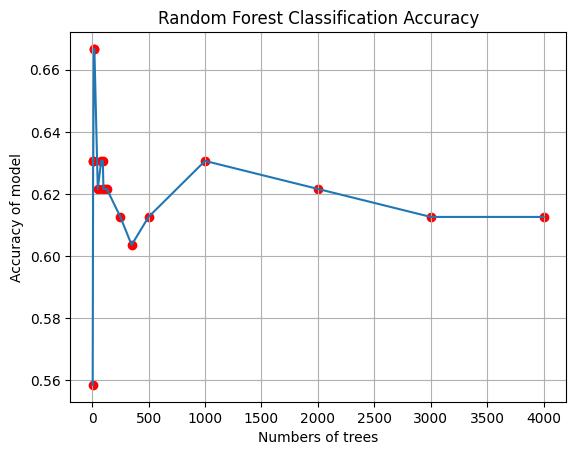

In [149]:
##Plotting the graph
plot.plot(n,accy)
plot.scatter(n,accy, color = "red")
plot.xlabel("Numbers of trees")
plot.ylabel("Accuracy of model")
plot.xlim()
plot.grid()
plot.title("Random Forest Classification Accuracy")

In [12]:
y_rf_cl

RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=42)

In [89]:
#Predict
lum_x_ = 3.32e31
dist_ = 253.92
bp_rp_ = 1.2
Absolute_G_ = 8
lum_o_ = 23.835
a_1_ = -1   # Not needed, you predict these
a_2_ = 1
E_p_ = 0.8

# Step 1: Create observational feature array (only 5 features)
source_obs = np.array([[lum_x_, dist_, Absolute_G_, bp_rp_, lum_o_]])
source_obs_scaled = scalar.transform(source_obs)

a1_pred = reg_a1.predict(source_obs_scaled)
a2_pred = reg_a2.predict(source_obs_scaled)
Ep_pred = reg_ep.predict(source_obs_scaled)

source_final = np.hstack([source_obs_scaled,a1_pred.reshape(-1,1),a2_pred.reshape(-1,1),Ep_pred.reshape(-1,1)])

# Step 6: Predict class
result = y_rf_cl.predict(source_final)
print("The new source belongs to the class:", class_1[int(result[0])])

ValueError: X has 5 features, but RobustScaler is expecting 6 features as input.

In [71]:
#Predict
lum_x_ = 2.9e34
dist_ = 2605
bp_rp_ = 0.74
Absolute_G_ = -5.72
lum_o_ = 10200
Temp_ = 6000
a_1_ = -1   
a_2_ = 1
E_p_ = 1

# Step 1: Create observational feature array (only 5 features)
source_obs = np.array([[lum_x_, dist_, Absolute_G_, bp_rp_, lum_o_]])
source_obs_scaled = scalar.transform(source_obs)

a1_pred = reg_a1.predict(source_obs_scaled)
a2_pred = reg_a2.predict(source_obs_scaled)
Ep_pred = reg_ep.predict(source_obs_scaled)

source_final = np.hstack([source_obs_scaled,a1_pred.reshape(-1,1),a2_pred.reshape(-1,1),Ep_pred.reshape(-1,1)])

# Step 6: Predict class
result = y_rf_cl.predict(source_final)
print("The new source belongs to the class:", class_1[int(result[0])])

The new source belongs to the class: SS_IB


In [25]:
importances = rf_cl.feature_importances_
for name, val in zip(["lum_x", "dist","bp_rp","Absolute_G", "lum_o","flux_ratio","G_bp_rp_ratio",
                      "f_ratio_G","f_ratio_Gbp","a_1","a_2","E_p","boundary"], importances):
    print(f"{name}: {val:.3f}")

lum_x: 0.086
dist: 0.070
bp_rp: 0.058
Absolute_G: 0.107
lum_o: 0.079
flux_ratio: 0.097
G_bp_rp_ratio: 0.148
f_ratio_G: 0.128
f_ratio_Gbp: 0.071
a_1: 0.050
a_2: 0.055
E_p: 0.030
boundary: 0.010


In [175]:
#Using cross_validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model with accuracy scoring
scores = cross_val_score(rf_cl,data_final,target_s, cv=cv, scoring='accuracy')

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation scores: [0.98387097 0.97580645 0.97304582 0.98113208 0.98113208]
Mean accuracy: 0.9789974784801322


In [24]:
#Using the model on 2164 eROSITA sources
df = pd.read_csv("Final Classification Result")
df1 = pd.read_csv("2164_parms.txt")
lum_x_1 = df["Luminosity (ergs/sec)"].to_numpy()
dist_1 = df["Distance (pc)"].to_numpy()
bp_rp_1 = df["bp_rp"].to_numpy()
Absolute_G_1 = df["Absolute G"].to_numpy()
Temp_1 = df["Temp (Kelvin)"].to_numpy()
lum_o_1 = df["luminosity_GAIA (ergs/sec)"].to_numpy()
radius_1 = df["RADIUS"].to_numpy()
flux_ratio_1 = df["flux_ratio_final"].to_numpy()
o_period_1 = df["Final periods (Days)"].to_numpy()
a_1_1 = df1["1"].to_numpy()
a_2_1 = df1["2"].to_numpy()
E_p_1 = df1["3"].to_numpy()

#Changing the elements to nan
lum_o_1[lum_o_1 == "--"] = np.nan
Temp_1[Temp_1 == "--"] = np.nan
bp_rp_1[bp_rp_1 == "--"] = np.nan
radius_1[radius_1 == "--"] = np.nan

lum_o_1 = lum_o_1.astype(float)
Temp_1 = Temp_1.astype(float)
bp_rp_1 = bp_rp_1.astype(float)
radius_1 = radius_1.astype(float)

print(len(lum_x_1))
print(len(dist_1))
print(len(Absolute_G_1))
print(len(bp_rp_1))
print(len(lum_o_1))

log_lum_x_1 = np.log10(lum_x_1)
#Boundary
flux_ratio_1 = np.log10(flux_ratio_1)
boundary_1 = bp_rp_1 - 3.5
G_bp_rp_ratio_1 = np.divide(Absolute_G_1, bp_rp_1)
f_ratio_G_1 = np.divide(flux_ratio_1,Absolute_G_1)
f_ratio_Gbp_1 = np.divide(flux_ratio_1 ,(bp_rp_1 * Absolute_G_1))
feature_period_known_1 = (~np.isnan(o_period_1)).astype(int).reshape(-1, 1)
feature_period_value_1 = np.nan_to_num(o_period_1, nan=0.0).reshape(-1, 1)

#Stacking the data
source_obs = np.column_stack((lum_x_1,dist_1,Absolute_G_1,bp_rp_1,lum_o_1,flux_ratio_1,
                            G_bp_rp_ratio_1,f_ratio_Gbp_1,feature_period_known_1,feature_period_value_1))

source_obs_t = imputer.transform(source_obs)

source_obs_scaled = scalar.transform(source_obs_t) 

a1_pred = reg_a1.predict(source_obs_scaled)
a2_pred = reg_a2.predict(source_obs_scaled)
Ep_pred = reg_ep.predict(source_obs_scaled)

source_final = np.hstack([source_obs_scaled,a1_pred.reshape(-1,1),a2_pred.reshape(-1,1),Ep_pred.reshape(-1,1)])

#Final Predict class
result = y_rf_cl.predict(source_final)
#print("The new source belongs to the class:", class_1[int(result[0])])

final_class_2164 = []

for i in result:
    final_class_2164.append(class_1[int(i)])
print(final_class_2164)

2165
2165
2165
2165
2165
['SS_IB', 'YSO', 'SS_IB', 'IB', 'CV', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'CV', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'CV', 'CV', 'YSO', 'SS_IB', 'CV', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'IB', 'CV', 'SS_IB', 'CV', 'SS_IB', 'IB', 'YSO', 'SS_IB', 'CV', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'SS_IB', 'CV', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'IB', 'SS_IB', 'CV', 'SS_IB', 'SS_IB', 'CV', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'IB', 'SS_IB', 'CV', 'IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'CV', 'CV', 'CV', 'SS_IB', 'CV', 'CV', 'CV', 'CV', 'SS_IB', 'SS_IB', 'IB', 'CV', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'IB',

In [25]:
Counter(final_class_2164)

Counter({'SS_IB': 1414, 'IB': 557, 'YSO': 135, 'CV': 58, 'XRB': 1})

In [26]:
#Using the model on 1005 eROSITA sources
df2 = pd.read_csv("New_1005")
df3 = pd.read_csv("1005_parms.txt")
lum_x_2 = df2["Luminosity"].to_numpy()
dist_2 = df2["Distance (pc)"].to_numpy()
bp_rp_2 = df2["bp_rp"].to_numpy()
Absolute_G_2 = df2["Absolute G"].to_numpy()
Temp_2 = df2["Temp (Kelvin)"].to_numpy()
lum_o_2 = df2["luminosity_GAIA (ergs/sec)"].to_numpy()
radius_2 = df2["RADIUS"].to_numpy()
flux_ratio_2 = df2["flux_ratio_final"].to_numpy()
o_period_2 = df2["Final periods (Days)"].to_numpy()
a_1_2 = df3["1"].to_numpy()
a_2_2 = df3["2"].to_numpy()
E_p_2 = df3["3"].to_numpy()

#Changing the elements to nan
lum_o_2[lum_o_2 == "--"] = np.nan
Temp_2[Temp_2 == "--"] = np.nan
bp_rp_2[bp_rp_2 == "--"] = np.nan
radius_2[radius_2 == "--"] = np.nan

lum_o_2 = lum_o_2.astype(float)
Temp_2 = Temp_2.astype(float)
bp_rp_2 = bp_rp_2.astype(float)
radius_2 = radius_2.astype(float)

print(len(lum_x_2))
print(len(dist_2))
print(len(Absolute_G_2))
print(len(bp_rp_2))
print(len(lum_o_2))

log_lum_x_2 = np.log10(lum_x_2)
#Boundary
flux_ratio_2 = np.log10(flux_ratio_2)
boundary_2 = bp_rp_2 - 3.5
G_bp_rp_ratio_2 = np.divide(Absolute_G_2, bp_rp_2)
f_ratio_G_2 = np.divide(flux_ratio_2,Absolute_G_2)
f_ratio_Gbp_2 = np.divide(flux_ratio_2 ,(bp_rp_2 * Absolute_G_2))
feature_period_known_2 = (~np.isnan(o_period_2)).astype(int).reshape(-1, 1)
feature_period_value_2 = np.nan_to_num(o_period_2, nan=0.0).reshape(-1, 1)

#Stacking the data
source_obs = np.column_stack((lum_x_2,dist_2,Absolute_G_2,bp_rp_2,lum_o_2,flux_ratio_2,
                            G_bp_rp_ratio_2,f_ratio_Gbp_2,feature_period_known_2,feature_period_value_2))

source_obs_t = imputer.transform(source_obs)

source_obs_scaled = scalar.transform(source_obs_t) 

a1_pred = reg_a1.predict(source_obs_scaled)
a2_pred = reg_a2.predict(source_obs_scaled)
Ep_pred = reg_ep.predict(source_obs_scaled)

source_final = np.hstack([source_obs_scaled,a1_pred.reshape(-1,1),a2_pred.reshape(-1,1),Ep_pred.reshape(-1,1)])

#Final Predict class
result = y_rf_cl.predict(source_final)
#print("The new source belongs to the class:", class_1[int(result[0])])

final_class_1005 = []

for i in result:
    final_class_1005.append(class_1[int(i)])
print(final_class_1005)

/tmp/ipykernel_3788/2037695836.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  lum_o_2[lum_o_2 == "--"] = np.nan
/tmp/ipykernel_3788/2037695836.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  Temp_2[Temp_2 == "--"] = np.nan
/tmp/ipykernel_3788/2037695836.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  bp_rp_2[bp_rp_2 == "--"] = np.nan
/tmp/ipykernel_3788/2037695836.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  radius_2[radius_2 == "--"] = np.nan


1005
1005
1005
1005
1005
['YSO', 'IB', 'SS_IB', 'IB', 'CV', 'IB', 'YSO', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'IB', 'CV', 'SS_IB', 'CV', 'SS_IB', 'IB', 'CV', 'SS_IB', 'IB', 'CV', 'IB', 'IB', 'SS_IB', 'CV', 'SS_IB', 'CV', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'YSO', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'YSO', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'YSO', 'IB', 'IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'IB', 'SS_IB', 'IB', 'IB', 'SS_IB', 'IB', 'CV', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'YSO', 'SS_I

In [27]:
Counter(final_class_1005)

Counter({'SS_IB': 696, 'IB': 228, 'YSO': 58, 'CV': 20, 'XRB': 3})

/tmp/ipykernel_3788/440405032.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  bp_rp_1[bp_rp_1 == "--"] = np.nan


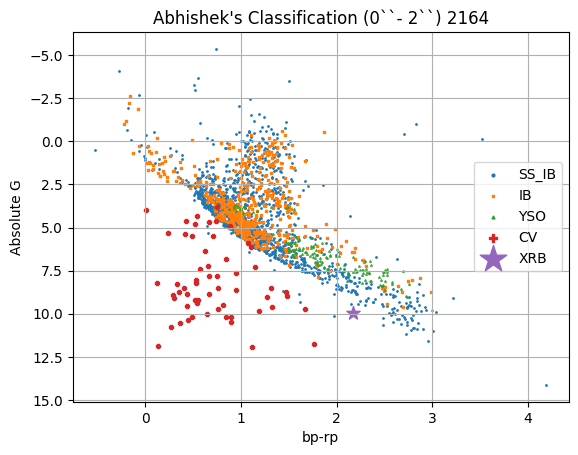

In [28]:
#HR diagram

#Plotting bp-rp Absolute G  plot
class_1 = ["SS_IB","IB","YSO","CV", "XRB"]
final_class_2164 = np.array(final_class_2164)
final_class_2164[final_class_2164  == "SS_IB"] = 0
final_class_2164[final_class_2164 == "IB"] = 1
final_class_2164[final_class_2164 == "YSO"] = 2
final_class_2164[final_class_2164  == "CV"] = 3
final_class_2164[final_class_2164  == "XRB"] = 4

final_class_2164 = final_class_2164.astype(int)

#Converting to float
bp_rp_1[bp_rp_1 == "--"] = np.nan
bp_rp_ = []
for i in bp_rp_1:
    bp_rp_.append(np.round(float(i),3))

Absolute_G_ = []
for i in Absolute_G_1:
    Absolute_G_.append(np.round(float(i),3))
    
bp_rp_ = np.array(bp_rp_)
Absolute_G_ = np.array(Absolute_G_)

#Column stacking with labels 
d1 = np.column_stack((bp_rp_,Absolute_G_))
label = [0,1,2,3,4]
grouped_data = {label: d1[final_class_2164 == label] for label in label}

#Plotting

markers = ['o', 's', '^', 'P', '*']
s = [1,1,1,7,100]

for label, points in grouped_data.items():
    plot.scatter(points[:,0], points[:,1], label = class_1[label],s = s[label], marker=markers[label])
    plot.legend(markerscale = 2)

# plot.scatter(bp_rp_,Absolute_G_, s = 1)
plot.gca().invert_yaxis()
plot.xlabel("bp-rp")
plot.ylabel("Absolute G")
plot.title("Abhishek's Classification (0``- 2``) 2164")
plot.grid()

/tmp/ipykernel_3788/4175369032.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  bp_rp_2[bp_rp_2 == "--"] = np.nan


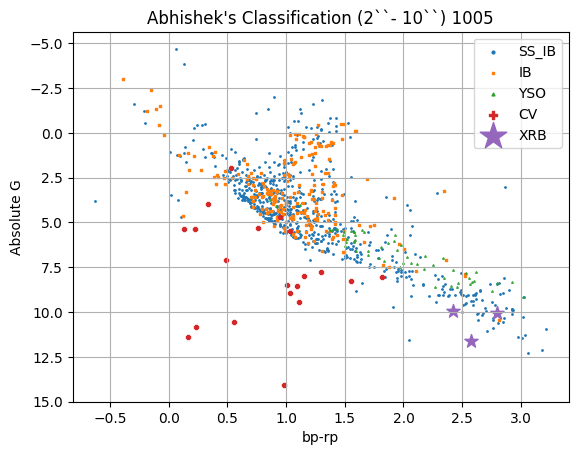

In [29]:
#HR diagram

#Plotting bp-rp Absolute G  plot
class_1 = ["SS_IB","IB","YSO","CV", "XRB"]
final_class_1005 = np.array(final_class_1005)
final_class_1005[final_class_1005  == "SS_IB"] = 0
final_class_1005[final_class_1005 == "IB"] = 1
final_class_1005[final_class_1005 == "YSO"] = 2
final_class_1005[final_class_1005  == "CV"] = 3
final_class_1005[final_class_1005  == "XRB"] = 4

final_class_1005 = final_class_1005.astype(int)

#Converting to float
bp_rp_2[bp_rp_2 == "--"] = np.nan
bp_rp_ = []
for i in bp_rp_2:
    bp_rp_.append(np.round(float(i),3))

Absolute_G_ = []
for i in Absolute_G_2:
    Absolute_G_.append(np.round(float(i),3))
    
bp_rp_ = np.array(bp_rp_)
Absolute_G_ = np.array(Absolute_G_)

#Column stacking with labels 
d1 = np.column_stack((bp_rp_,Absolute_G_))
label = [0,1,2,3,4]
grouped_data = {label: d1[final_class_1005 == label] for label in label}

#Plotting

markers = ['o', 's', '^', 'P', '*']
s = [1,1,1,7,100]

for label, points in grouped_data.items():
    plot.scatter(points[:,0], points[:,1], label = class_1[label],s = s[label], marker=markers[label])
    plot.legend(markerscale = 2)

# plot.scatter(bp_rp_,Absolute_G_, s = 1)
plot.gca().invert_yaxis()
plot.xlabel("bp-rp")
plot.ylabel("Absolute G")
plot.title("Abhishek's Classification (2``- 10``) 1005")
plot.grid()

In [19]:
df3

,0,1,2,3,4
0,2168.0,-0.478916,3.245214,0.825198,0.736751
1,2182.0,2.016782,0.000000,0.000000,7.421295
2,2185.0,2.046622,0.000000,0.000000,5.138344
3,2186.0,1.000000,0.000000,0.000000,1.648262
4,2188.0,-2.109153,2.254782,0.950750,1.068937
...,...,...,...,...,...
1000,4451.0,1.000000,0.000000,0.000000,0.650054
1001,4457.0,1.000000,0.000000,0.000000,1.397253
1002,4458.0,2.124558,0.000000,0.000000,1.231145
1003,4462.0,1.000000,0.000000,0.000000,0.842685


In [13]:
final_class_2164

['SS_IB',
 'YSO',
 'SS_IB',
 'IB',
 'CV',
 'SS_IB',
 'CV',
 'SS_IB',
 'SS_IB',
 'IB',
 'SS_IB',
 'SS_IB',
 'CV',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'CV',
 'CV',
 'CV',
 'IB',
 'SS_IB',
 'CV',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'CV',
 'IB',
 'CV',
 'SS_IB',
 'CV',
 'SS_IB',
 'IB',
 'YSO',
 'SS_IB',
 'CV',
 'IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'CV',
 'SS_IB',
 'CV',
 'IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'IB',
 'IB',
 'SS_IB',
 'CV',
 'SS_IB',
 'SS_IB',
 'CV',
 'SS_IB',
 'IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'IB',
 'SS_IB',
 'IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'IB',
 'SS_IB',
 'SS_IB',
 'IB',
 'SS_IB',
 'CV',
 'IB',
 'IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'SS_IB',
 'IB',
 'SS_IB',
 'CV',
 'IB',
 'IB',
 'SS_IB',
 'XRB',
 'SS_IB',
 'CV',
 'CV',
 'CV',
 'CV',
 'SS_IB',
 'CV',
 'CV',
 'CV',
 'CV',
 'SS_IB',
 'SS_IB',
 'IB',
 'CV',
 'SS

In [ ]:
# df= pd.read_csv("New_Sources")
# df["Abhishek Classification"] = final_class
# df.to_csv("New_Sources")

In [11]:
#Checking with Simbad classification
data_2 = pd.read_csv("e-ROSITA NEW RESULTS - EROSITA+GAIA (1).csv")
sr_class_vikas = data_2["New source class"]
Counter(sr_class_vikas)

Counter({'SS_IB': 1306,
         'IB': 417,
         'YSO': 252,
         'Not_known': 129,
         'CV': 49,
         'LPV': 7,
         'XRB': 5})

In [18]:
# ##Creating the csv file
# df_final = df
# df_final["a1"] = a_1_1
# df_final["a2"] = a_2_1
# df_final["E_p"] = E_p_1
# df_final["Abhishek's Classification"] = final_class
# #df_final.to_csv("Final Classification Result")

In [6]:
#Selecting only CV and XRB
df_f = pd.read_csv("New_Sources")
CV_row = df_f[ (df_f["Abhishek’s  Classification"].isin(["CV"]))]
XRB_row = df_f[((df_f["Abhishek’s  Classification"].isin(["XRB"])))]

CV_row.to_csv("CV_test_2300")
XRB_row.to_csv("XRB_test_2300")

In [147]:
final_class

array([1, 2, 1, ..., 0, 1, 0])

/tmp/ipykernel_3730/3588532357.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class  == "SS_IB"] = 0
/tmp/ipykernel_3730/3588532357.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class == "IB"] = 1
/tmp/ipykernel_3730/3588532357.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class == "YSO"] = 2
/tmp/ipykernel_3730/3588532357.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class  == "CV"] = 3
/tmp/ipykernel_3730/3588532357.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_cl

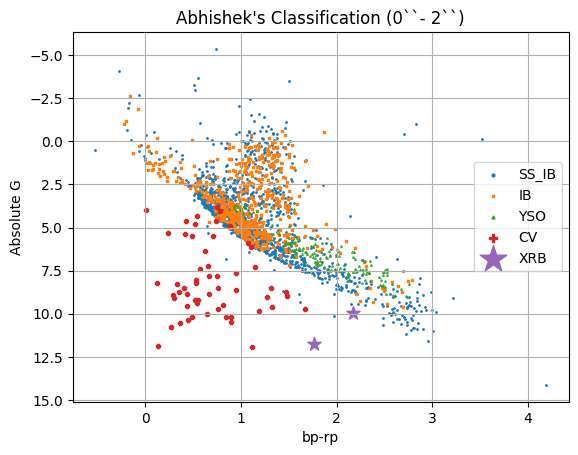

In [16]:
#HR diagram

#Plotting bp-rp Absolute G  plot
class_1 = ["SS_IB","IB","YSO","CV", "XRB"]
final_class = np.array(final_class)
final_class[final_class  == "SS_IB"] = 0
final_class[final_class == "IB"] = 1
final_class[final_class == "YSO"] = 2
final_class[final_class  == "CV"] = 3
final_class[final_class  == "XRB"] = 4

final_class = final_class.astype(int)

#Converting to float
bp_rp_1[bp_rp_1 == "--"] = np.nan
bp_rp_ = []
for i in bp_rp_1:
    bp_rp_.append(np.round(float(i),3))

Absolute_G_ = []
for i in Absolute_G_1:
    Absolute_G_.append(np.round(float(i),3))
    
bp_rp_ = np.array(bp_rp_)
Absolute_G_ = np.array(Absolute_G_)

#Column stacking with labels 
d1 = np.column_stack((bp_rp_,Absolute_G_))
label = [0,1,2,3,4]
grouped_data = {label: d1[final_class == label] for label in label}

#Plotting

markers = ['o', 's', '^', 'P', '*']
s = [1,1,1,7,100]

for label, points in grouped_data.items():
    plot.scatter(points[:,0], points[:,1], label = class_1[label],s = s[label], marker=markers[label])
    plot.legend(markerscale = 2)

# plot.scatter(bp_rp_,Absolute_G_, s = 1)
plot.gca().invert_yaxis()
plot.xlabel("bp-rp")
plot.ylabel("Absolute G")
plot.title("Abhishek's Classification (0``- 2``)")
plot.grid()

In [ ]:
d1[2059]

array([  nan, 3.806])

Text(0.5, 1.0, "Simbad's Classification")

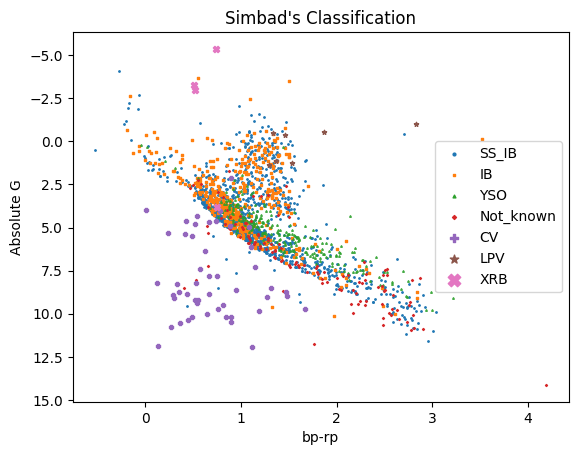

In [ ]:
#H-R diagram of Simbad Classification
df = pd.read_csv("e-ROSITA NEW RESULTS - EROSITA+GAIA (1).csv")
class_2 = ["SS_IB", "IB","YSO", "Not_known", "CV", "LPV", "XRB"]
simbad_class = df["New source class"].dropna().to_numpy()
simbad_class

simbad_class[simbad_class == "SS_IB"] = 0
simbad_class[simbad_class  == "IB"] = 1
simbad_class[simbad_class == "YSO"] = 2
simbad_class[simbad_class == "Not_known"] = 3
simbad_class[simbad_class  == "CV"] = 4
simbad_class[simbad_class  == "LPV"] = 5
simbad_class[simbad_class  == "XRB"] = 6

label = [0,1,2,3,4,5,6]
grouped_data = {label: d1[simbad_class == label] for label in label}

for label, points in grouped_data.items():
    plot.scatter(points[:,0], points[:,1], label = class_2[label],s = s[label], marker=markers[label])
    plot.legend(markerscale = 2)

plot.gca().invert_yaxis()
plot.xlabel("bp-rp")
plot.ylabel("Absolute G")
plot.title("Simbad's Classification")

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

df1 = pd.read_excel("New  Variables and Transients.xlsx")
sr_class = df1["Source Class"].to_numpy()

for i in range(len(sr_class)):
    if sr_class[i] == "IB_ACS":
        sr_class[i] = "IB"
        
df1["New Source Class"] = sr_class
#df1.to_excel("New  Variables and Transients.xlsx")

/tmp/ipykernel_15202/2851968416.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class  == "SS_IB"] = 0
/tmp/ipykernel_15202/2851968416.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class == "IB"] = 1
/tmp/ipykernel_15202/2851968416.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class == "YSO"] = 2
/tmp/ipykernel_15202/2851968416.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[final_class  == "CV"] = 3
/tmp/ipykernel_15202/2851968416.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  final_class[fin

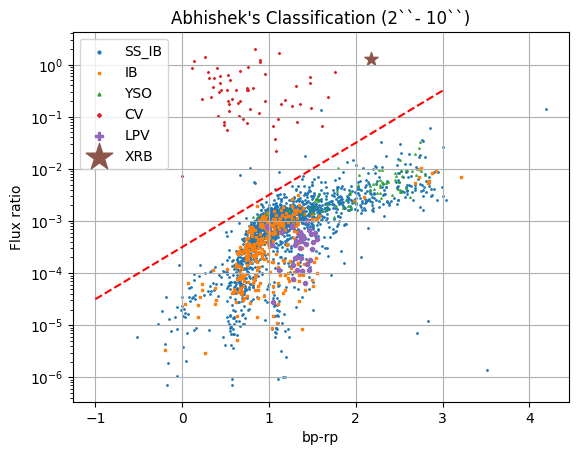

In [38]:
#HR diagram

#Plotting bp-rp Absolute G  plot
class_1 = ["SS_IB","IB","YSO","CV", "LPV", "XRB"]
final_class = np.array(final_class)
final_class[final_class  == "SS_IB"] = 0
final_class[final_class == "IB"] = 1
final_class[final_class == "YSO"] = 2
final_class[final_class  == "CV"] = 3
final_class[final_class  == "LPV"] = 4
final_class[final_class  == "XRB"] = 5

final_class = final_class.astype(int)

#Converting to float
bp_rp_1[bp_rp_1 == "--"] = np.nan
bp_rp_ = []
for i in bp_rp_1:
    bp_rp_.append(np.round(float(i),3))

Absolute_G_ = []
for i in Absolute_G_1:
    Absolute_G_.append(np.round(float(i),3))
    
flux_ratio_ = []
for i in flux_ratio_1:
    flux_ratio_.append(np.round(float(i),9))
    
bp_rp_ = np.array(bp_rp_)
Absolute_G_ = np.array(Absolute_G_)
flux_ratio_ = np.array(flux_ratio_)

#Column stacking with labels 
d1 = np.column_stack((bp_rp_,flux_ratio_))
label = [0,1,2,3,4,5]
grouped_data = {label: d1[final_class == label] for label in label}

#Plotting

markers = ['o', 's', '^', 'D', 'P', '*']
s = [1,1,1,1,7,100]

for label, points in grouped_data.items():
    plot.scatter(points[:,0], points[:,1], label = class_1[label],s = s[label], marker=markers[label])
    plot.legend(markerscale = 2)

# plot.scatter(bp_rp_,Absolute_G_, s = 1)
#plot.gca().invert_yaxis()
plot.xlabel("bp-rp")
plot.ylabel("Flux ratio")
plot.yscale("log")
plot.title("Abhishek's Classification (2``- 10``)")
plot.grid()

def rodriguez_line(x,m,c):
    return 10**(m*x + c)

x = np.linspace(-1,3,100)
plot.plot(x, rodriguez_line(x,m=1,c = -3.5), "r--")

In [23]:
flux_ratio_

array([0.001197, 0.00359 , 0.000605, ..., 0.001803, 0.000785, 0.001774])

In [26]:
df1 = pd.read_excel("New  Variables and Transients.xlsx")
sr_class = df1["Source Class"].to_numpy()
Counter(sr_class)

Counter({'SS_IB': 417,
         'IB': 160,
         'YSO': 105,
         'CV': 38,
         'LPV': 12,
         nan: 12,
         'XRB': 3})

In [25]:
df = pd.read_csv("New_Sources")
Counter(df["Simbad Classification"])

Counter({nan: 531,
         'High Proper Motion Star': 417,
         'Star': 415,
         'Spectroscopic Binary': 158,
         'Rotating Variable': 149,
         'T Tauri Star': 97,
         'Eclipsing Binary': 84,
         'Orion Variable': 58,
         'Double or Multiple Star': 58,
         'Young Stellar Object Candidate': 42,
         'RS CVn Variable': 38,
         'BY Dra Variable': 37,
         'Young Stellar Object': 37,
         'Low-mass Star': 28,
         'Eruptive Variable': 25,
         'Cataclysmic Binary': 24,
         'Emission-line Star': 19,
         'Variable Star': 18,
         'Chemically Peculiar Star': 12,
         'X-ray Source': 8,
         'alpha2 CVn Variable': 5,
         'Pulsating Variable': 5,
         'Long-Period Variable': 4,
         'delta Sct Variable': 3,
         'Cataclysmic Binary Candidate': 3,
         'Be Star': 2,
         'Hot Subdwarf Candidate': 2,
         'Red Giant Branch star': 2,
         'Long-Period Variable Candidate': 2,
    